# Building Unimodal Image Model

In [1]:
cd ..

/notebooks/MultimodalTweetsClassification


In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [4]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [5]:
path_img = path/'data_image'

In [6]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [7]:
#reading csv files and doing initial necessary processing
data_info_image,test_data_info_image = get_dataframe(*get_tsv_data_files('Informativeness_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


In [8]:
print(f"shape of data: {data_info_image.shape}\n")
print(f"train set: {data_info_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_info_image['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_info_image.shape}\n")

shape of data: (11173, 10)

train set: 9600
valid set: 1573
shape of test data: (1534, 9)



In [9]:
data_info_image.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image,is_valid
0,california_wildfires,917793137925459968,917793137925459968_0,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False
1,california_wildfires,917793137925459968,917793137925459968_1,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False
2,california_wildfires,917793137925459968,917793137925459968_2,california wildfires destroy more than structu...,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False
3,california_wildfires,917815040962695168,917815040962695168_0,photos of california destructive wildfires via,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False
4,california_wildfires,917815040962695168,917815040962695168_1,photos of california destructive wildfires via,data_image/california_wildfires/10_10_2017/917...,informative,informative,informative,Positive,False


In [10]:
test_data_info_image.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,srilanka_floods,878185882431389696,878185882431389696_0,cristofer clemente mora now in nd at aguille d...,data_image/srilanka_floods/23_6_2017/878185882...,not_informative,not_informative,not_informative,Positive
1,hurricane_maria,910542719864397824,910542719864397824_0,hurricane maria batters puerto rico as cat mon...,data_image/hurricane_maria/20_9_2017/910542719...,informative,informative,informative,Positive
2,hurricane_maria,913009824195104768,913009824195104768_0,am maria update holding steady as strong tropi...,data_image/hurricane_maria/27_9_2017/913009824...,informative,informative,informative,Positive
3,hurricane_maria,916053383383011328,916053383383011328_0,is hosting puerto rico benefict concert tonight,data_image/hurricane_maria/5_10_2017/916053383...,informative,informative,informative,Positive
4,hurricane_maria,922230253359116288,922230253359116288_0,vet in puerto rico hurricane worse than war sh...,data_image/hurricane_maria/22_10_2017/92223025...,not_informative,not_informative,not_informative,Positive


In [11]:
#creating text databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_info_image,path,224)
test_data_img = get_test_image_data(test_data_info_image,path,224)

In [12]:
# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

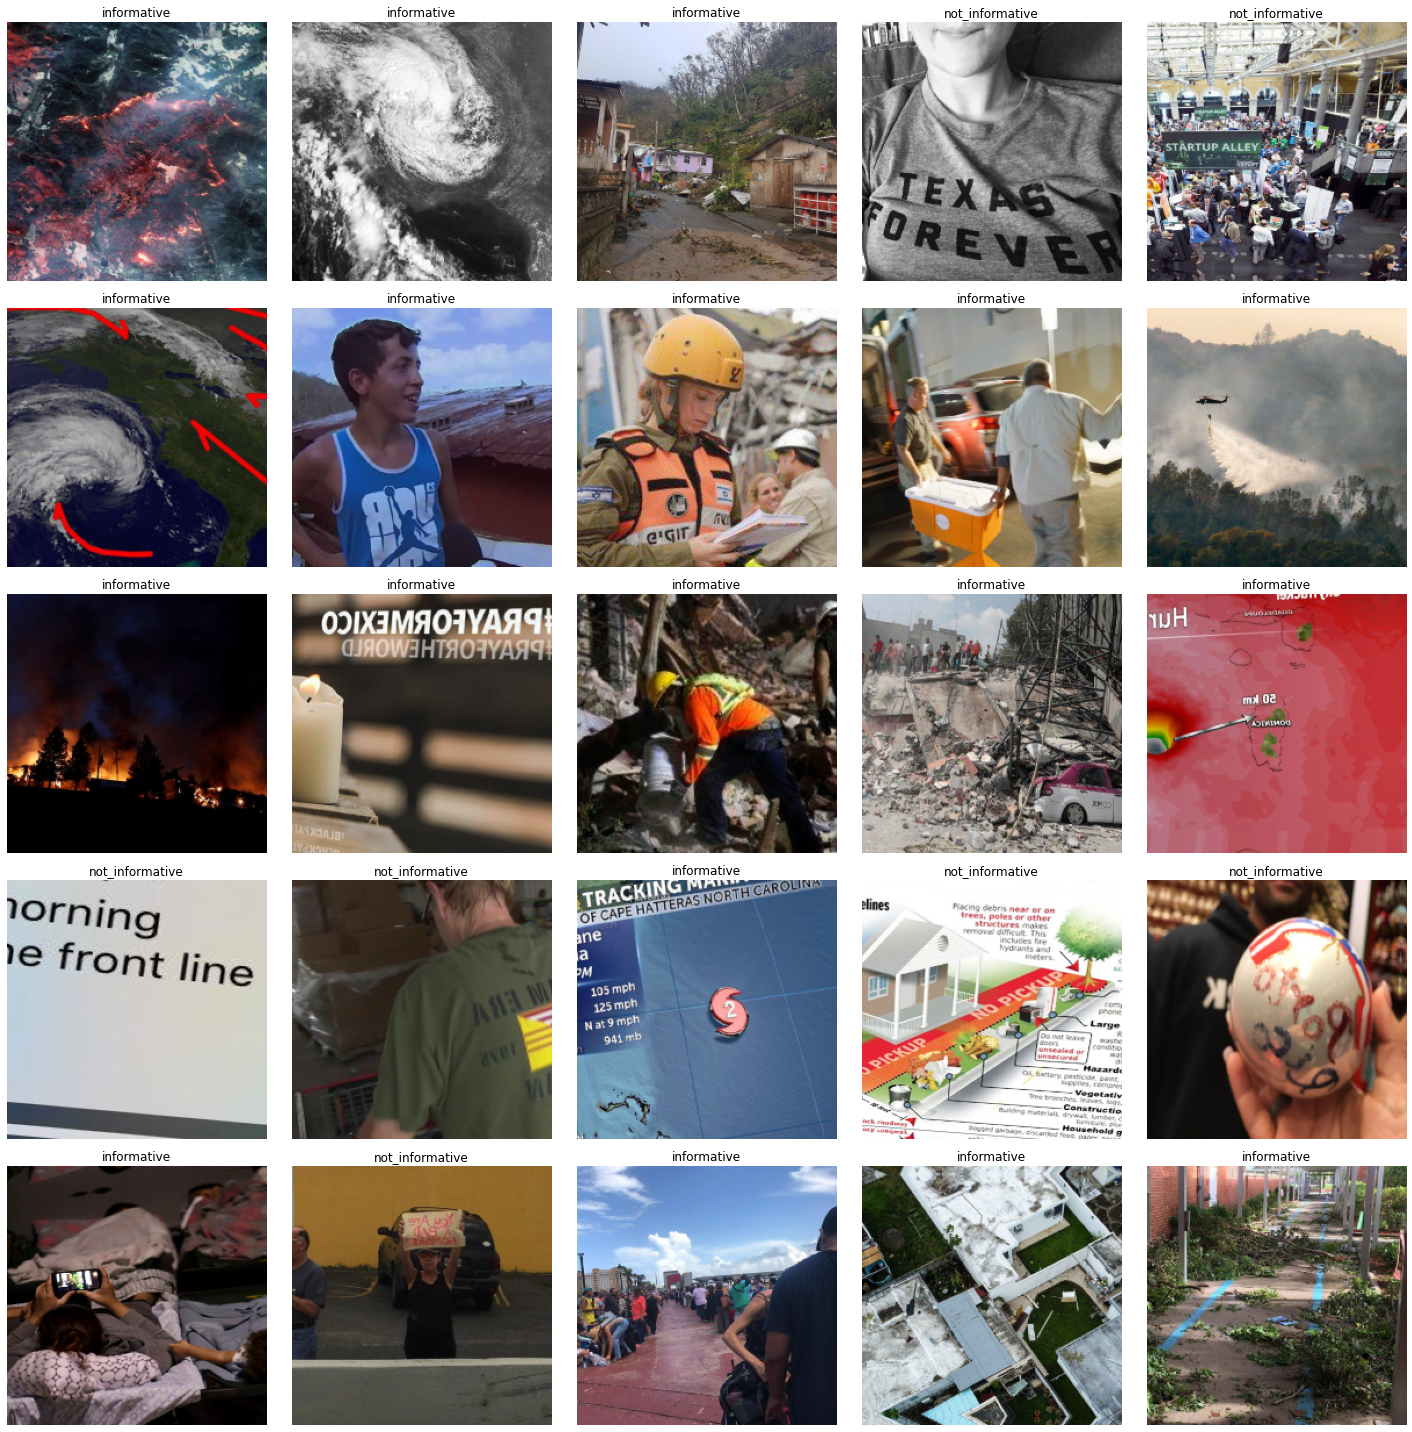

In [13]:
# showing the data with corresponding label
data_img.show_batch()

In [14]:
# importing pretrained Resnet50 model and making learner object consist of data,model,metrics and callbacks for training
arch = models.resnet50
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)])          

In [16]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn_img.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


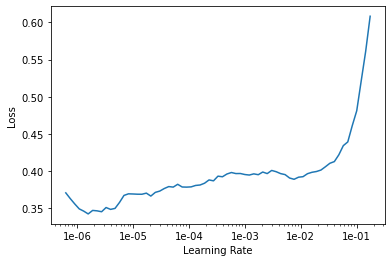

In [17]:
learn_img.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.793381,0.546165,0.774952,0.754803,0.800244,0.782036,0.774952,0.760293,0.780605,01:19
1,0.675511,0.473775,0.806739,0.781917,0.817594,0.801267,0.806739,0.788922,0.809936,01:19
2,0.623030,0.465162,0.809917,0.785752,0.822237,0.807090,0.809917,0.793138,0.813326,01:18


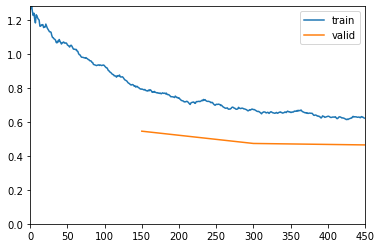

In [22]:
# training the model's top layer's keeping other layer's in freezing mode, all the metric shown here, have been
# evaluted on validation set
lr = 0.0001
learn_img.fit_one_cycle(3, slice(lr))

In [23]:
# unfreezing bottom layer's
learn_img.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


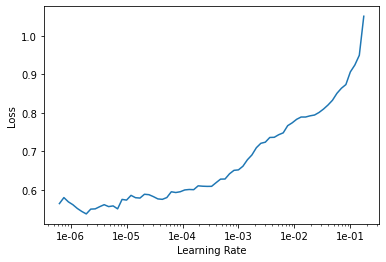

In [24]:
learn_img.lr_find()
learn_img.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.608470,0.467335,0.816910,0.794048,0.814899,0.786136,0.816910,0.789790,0.815662,01:28
1,0.485063,0.458780,0.816275,0.791875,0.816184,0.791586,0.816275,0.791730,0.816229,01:28
2,0.413814,0.411833,0.818818,0.816405,0.817974,0.758926,0.818818,0.776571,0.809862,01:28
3,0.385011,0.432150,0.815639,0.803272,0.812101,0.764456,0.815639,0.778097,0.809372,01:28
4,0.344482,0.360029,0.833439,0.814994,0.830952,0.800915,0.833439,0.807126,0.831537,01:28
5,0.309437,0.407553,0.827082,0.803874,0.827432,0.805065,0.827082,0.804463,0.827251,01:28
6,0.271962,0.350872,0.832804,0.821121,0.829953,0.789088,0.832804,0.801341,0.828431,01:28
7,0.203362,0.380970,0.841068,0.828635,0.838447,0.802154,0.841068,0.812828,0.837740,01:28


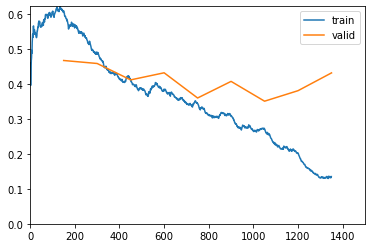

Better model found at epoch 0 with accuracy value: 0.8169103860855103.
Better model found at epoch 2 with accuracy value: 0.8188175559043884.
Epoch 3: reducing lr to 0.00019009692640269477
Better model found at epoch 4 with accuracy value: 0.833439290523529.
Epoch 5: reducing lr to 0.00012225240438725786
Epoch 7: reducing lr to 3.7651669210047406e-05
Better model found at epoch 7 with accuracy value: 0.8410680294036865.
Epoch 8: early stopping
Epoch 8: reducing lr to 9.90387359730526e-06
Better model found at epoch 8 with accuracy value: 0.8512396812438965.


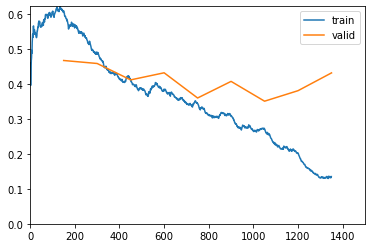

In [25]:
#training model the with all the layer's and saving the best one, and displaying the loss during training
learn_img.fit_one_cycle(10, slice(1e-4, 1e-3),
                        callbacks=[SaveModelCallback(learn_img,every='improvement', monitor='accuracy', name='best')])

In [26]:
# making interpretation on dev split
interp = ClassificationInterpretation.from_learner(learn_img)

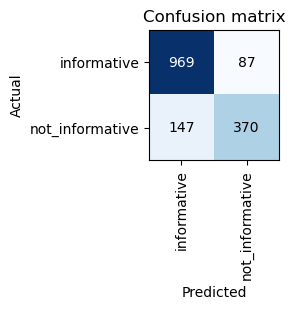

In [27]:
# plotting confusion matrix
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)

In [28]:
#making predictions on validation set to use it in classification report
preds,y,losses = learn_img.get_preds(ds_type=DatasetType.Valid,with_loss=True)
y_preds = preds.argmax(1)

In [29]:
target_names = ['Informative', 'Non-Informative']

print(classification_report(y, y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    Informative       0.87      0.92      0.89      1056
Non-Informative       0.81      0.72      0.76       517

       accuracy                           0.85      1573
      macro avg       0.84      0.82      0.83      1573
   weighted avg       0.85      0.85      0.85      1573



In [30]:
learn_img.validate(data_img.test_dl,metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.46340635,
 tensor(0.8475),
 tensor(0.8294),
 tensor(0.8460),
 tensor(0.8211),
 tensor(0.8475),
 tensor(0.8250),
 tensor(0.8465)]

In [31]:
preds,y,losses = learn_img.get_preds(ds_type=DatasetType.Test,with_loss=True)
y_preds = preds.argmax(1)
print(classification_report(y, y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    Informative       0.88      0.90      0.89      1030
Non-Informative       0.78      0.74      0.76       504

       accuracy                           0.85      1534
      macro avg       0.83      0.82      0.82      1534
   weighted avg       0.85      0.85      0.85      1534



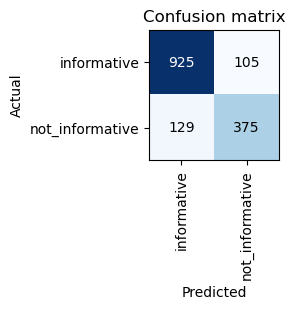

In [32]:
#making interpretation on test split
interp = ClassificationInterpretation.from_learner(learn_img,ds_type=DatasetType.Test)
interp.plot_confusion_matrix(figsize=(3,3), dpi=100)

In [33]:
learn_img.save("Informative_image_only")